# Basic model introduction

This page will introduce you to how to build and run a simple compartmental disease model with summer.
In this example, we will create a SIR compartmental model for some fictional disease. In this model there will be:

- three compartments: susceptible (S), infected (I) and recovered (R)
- a starting population of 1000 people, with 10 of them infected (and infectious)
- an evaluation timespan from years 1990 to 2010 in 0.1 year steps
- inter-compartmental flows for infection, deaths and recovery

First, let's import the summer library and create a new [CompartmentalModel](/api/model.html) object.

In [1]:
from summer import CompartmentalModel

model = CompartmentalModel(
    times=[1990, 2010],
    compartments=["S", "I", "R"],
    infectious_compartments=["I"],
    timestep=0.1,
)

# View a description of the model compartments
model.compartments

[S, I, R]

## Adding a population 

Initially the model compartments are all empty. Let's add:

- 990 people to the susceptible (S) compartment, plus
- 10 in the infectious (I) compartment.

In [2]:
# Add people to the model
model.set_initial_population(distribution={"S": 990, "I": 10})

# View the initial population
model.initial_population

array([990.,  10.,   0.])

## Adding intercompartmental flows 

Now, let's add some flows between the compartments. These flows will define the dynamics of our ficticious disease. We will add:

- an infection flow from S to I (using frequency dependent transmission)
- a recovery flow from I to R
- an infection death flow, that impacts people in the I compartment

In [3]:
# Susceptible people can get infected.
model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")

# Infectious people take 3 years, on average, to recover.
model.add_sojourn_flow(name="recovery", sojourn_time=3, source="I", dest="R")

# Add an infection-specific death flow to the I compartment.
model.add_death_flow(name="infection_death", death_rate=0.05, source="I")

# Inspect new flows.
model._flows

[<InfectionFrequencyFlow 'infection' from S to I>,
 <SojournFlow 'recovery' from I to R>,
 <DeathFlow 'infection_death' from I>]

## Running the model

Now we can calculate the outputs for the model over the requested time period. 
The model calculates the compartment sizes by solving a differential equation (defined by the flows we just added) over the requested time period.

In [4]:
model.run()

## Print the model outputs

The model's results are available in a NumPy array named `model.outputs`. 
This array is available after the model has been run. Let's have a look at what's inside:

In [5]:
# Force NumPy to format the output array nicely. 
import numpy as np
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

# View the first 20 timesteps of the output array.
model.outputs[:20]

array([[990.00, 10.00, 0.00],
       [987.96, 11.65, 0.34],
       [985.58, 13.56, 0.75],
       [982.82, 15.79, 1.21],
       [979.62, 18.36, 1.76],
       [975.91, 21.34, 2.39],
       [971.62, 24.79, 3.12],
       [966.66, 28.77, 3.98],
       [960.93, 33.36, 4.97],
       [954.34, 38.63, 6.11],
       [946.76, 44.68, 7.44],
       [938.08, 51.60, 8.97],
       [928.16, 59.49, 10.74],
       [916.90, 68.41, 12.78],
       [904.13, 78.49, 15.11],
       [889.66, 89.87, 17.80],
       [873.37, 102.64, 20.86],
       [855.12, 116.86, 24.37],
       [834.83, 132.58, 28.34],
       [812.45, 149.78, 32.84]])

## Plot the outputs

You can get a better idea of what is going on inside the model by visualizing how the compartment sizes change over time.

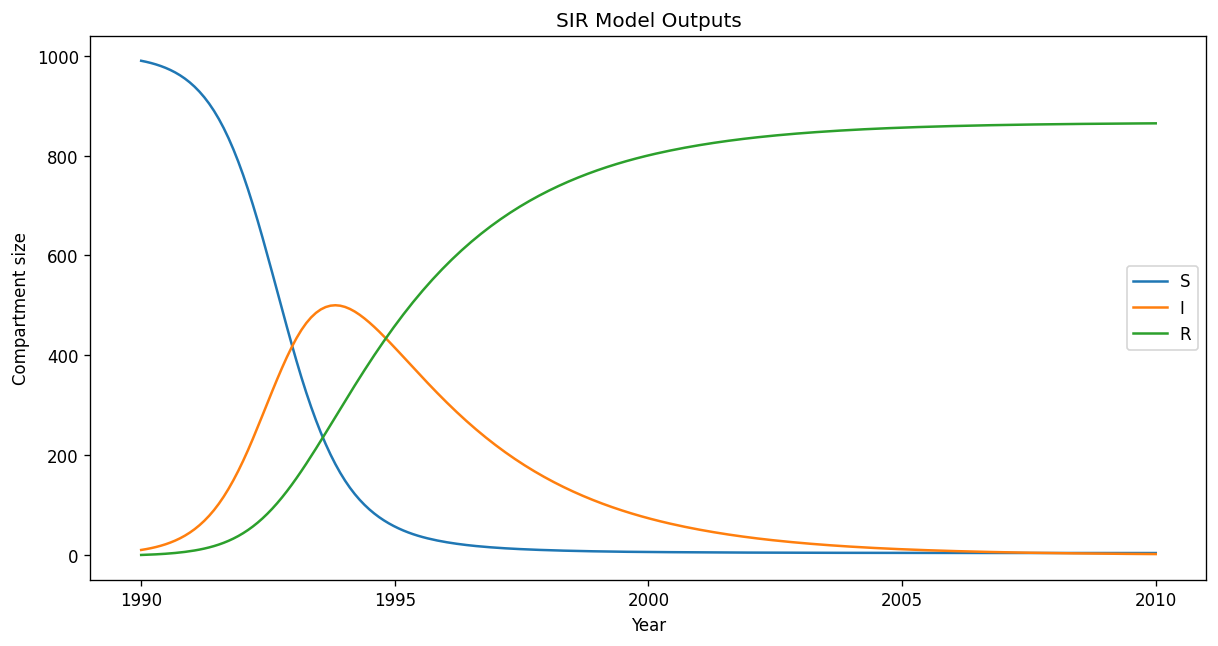

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)

# Add each compartment to the plot.
for i in range(model.outputs.shape[1]):
    ax.plot(model.times, model.outputs.T[i])

ax.set_title("SIR Model Outputs")
ax.set_xlabel("Year")
ax.set_ylabel("Compartment size")
ax.legend(["S", "I", "R"])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
plt.show()

## Summary

That's it for now, now you know how to:

- Create a model
- Add a population
- Add flows
- Run the model
- Access and visualize the outputs

A detailed API reference for the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)

## Bonus: how the model works inside

This section presents a code snippet showing you an approximation of what is happening inside the model we just built and ran, (using the [Euler method](https://en.wikipedia.org/wiki/Euler_method) to solve the ODE defined by the model).

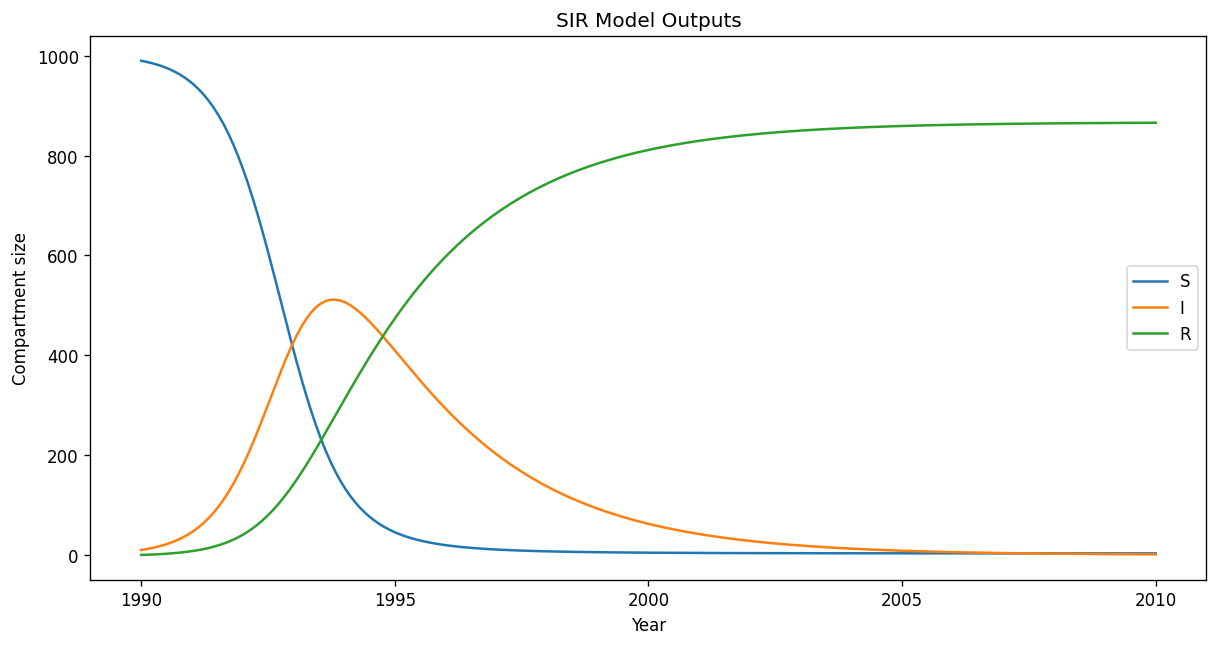

In [12]:
import numpy as np
import matplotlib.pyplot as plt

TIMESTEP = 0.1
START_TIME = 1990
END_TIME = 2010

# Get times
time_period = END_TIME - START_TIME + 1
num_steps = time_period / TIMESTEP
times = np.linspace(START_TIME, END_TIME, num=int(num_steps))

# Define initial conditions
initial_conditions = np.array([990.0, 10.0, 0.0])  # S, I, R

# Define outputs
outputs = np.zeros((int(num_steps), 3))
outputs[0] = initial_conditions

# Calculate outputs for each timestep
for t_idx, t in enumerate(times):
    if t_idx == 0:
        continue

    flow_rates = np.zeros(3)
    compartment_sizes = outputs[t_idx - 1 ]

    # Susceptible people can get infected (frequency-dependent).
    contact_rate = 2.0
    num_sus = compartment_sizes[0]
    num_inf = compartment_sizes[1]
    num_pop = compartment_sizes.sum()
    force_of_infection = contact_rate * num_inf / num_pop
    infection_flow_rate = force_of_infection * num_sus
    flow_rates[0] -= infection_flow_rate
    flow_rates[1] += infection_flow_rate

    # Infectious people take 3 years, on average, to recover.
    sojourn_time = 3.0
    num_inf = compartment_sizes[1]
    recovery_flow_rate = num_inf / sojourn_time
    flow_rates[1] -= recovery_flow_rate
    flow_rates[2] += recovery_flow_rate
    
    # Add an infection-specific death flow to the I compartment.
    death_rate = 0.05
    num_inf = compartment_sizes[1]
    recovery_flow_rate = num_inf * death_rate
    flow_rates[1] -= recovery_flow_rate
    
    # Calculate comeprtment sizes at next timestep given flowrates
    outputs[t_idx] = compartment_sizes + flow_rates * TIMESTEP  
    
# Plot the results as a function of time for S, I, R respectively
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)

# Add each compartment to the plot.
for i in range(outputs.shape[1]):
    ax.plot(times, outputs.T[i])

ax.set_title("SIR Model Outputs")
ax.set_xlabel("Year")
ax.set_ylabel("Compartment size")
ax.legend(["S", "I", "R"])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
plt.show()